In [1]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = LOCAL

train = pd.read_csv(source + 'train_features.csv')
X_test = pd.read_csv(source + 'test_features.csv')
target = pd.read_csv(source + 'train_labels.csv')
label = target['status_group']

# Split train into train & val
X_train, X_val, y_train, y_val= train_test_split(train, label, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (14358, 40), (47520,), (11880,))

In [10]:
selected_features = [
    'amount_tsh',
    'date_recorded',
    'gps_height',
    'basin',
    'region',
    'district_code',
    'population',
    'scheme_management',
    'construction_year',
    'extraction_type_class',
    'management_group',
    'payment',
    'quality_group',
    'quantity',
    'source_type',
    'source_class', 
    'waterpoint_type',
    'funder',
    'installer', 
    'latitude',
    'longitude'
]

def select_features(df, features):
    '''
    Subsets dataframe based on list of columns names accepted 
    as a parameter.
    '''
    return df[features]

In [11]:
X_train = select_features(X_train, features=selected_features)
X_val = select_features(X_val, features=selected_features)
X_test = select_features(X_test, features=selected_features)
X_train.shape, X_val.shape, X_test.shape

((47520, 21), (11880, 21), (14358, 21))

In [40]:
def clean_data (X):
    X = X.copy()
    
    # convert all strings to lowercase
    cat_features = X.select_dtypes('object').columns.tolist()
    for feat in cat_features:
        X[feat] = X[feat].str.lower()
        
    # Replace -2.00000e-08 with np.nan
    X['latitude'] = X['latitude'].replace(-2.000000e-08, np.nan)
    
    clean_features = [
        'gps_height',
        'population',
        'amount_tsh',
        'construction_year',
        'latitude',
        'longitude'
    ]
    
    for feat in clean_features:
        # Replace values=0.0 with np.nan
        X[feat] = X[feat].replace(0, np.nan)
        
        # fill nan with mean using region and district code
        X[feat] = X[feat].fillna(X.groupby(['region', 'district_code'])[feat].transform('mean'))
        
        # fill nan with mean of region if district code is missing
        X[feat] = X[feat].fillna(X.groupby(['region'])[feat].transform('mean'))
        
        # fill nan with general mean if no region or district code
        X[feat] = X[feat].fillna(X[feat].mean())
        
    # fillna of scheme_management with 'unknow' and combine low count values into 'other'
    X['scheme_management'] = X['scheme_management'].fillna('unknown')
    X['scheme_management'] = X['scheme_management'].replace({
        'swc':'Other',
        'trust':'Other',
        'none':'Other',
        'company': 'Other'
    })
    
    # make date_recorded datetime type
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
        
    return X

In [41]:
X_train = clean_data(X_train)
X_val = clean_data(X_val)
X_test = clean_data(X_test)

X_train.shape, X_val.shape, X_test.shape

((47520, 21), (11880, 21), (14358, 21))

In [79]:
def feature_eng(X):
    X = X.copy()
    
    # create month and year features from date_recorded
    X['month'] = X['date_recorded'].dt.month
    X['year'] = X['date_recorded'].dt.year
    
    # create a pump age feature
    X['pump_age'] = (X['year'].max() - X['construction_year'])
    
    # create seasons based on month
    X['hot_dry'] = (X['month'] == 12) | (X['month'] < 3)     # Dec. - Feb.
    X['cool_dry'] = (X['month'] > 5) & (X['month'] < 11)     # Jun. - Oct
    X['light_rain'] = (X['month'] == 3) | (X['month'] == 11) # Mar. & Nov.
    X['heavy_rain'] = (X['month'] == 4) | (X['month'] == 5)  # Apr. & May
    
    # create installer features
    X['dwe_installer'] = (X['installer'] == 'dwe')
    X['gov_installer'] = (X['installer'] == 'government')
     
    minor_installer = X['installer'].value_counts()[X['installer'].value_counts() <= 25]
    X['minor_installer'] = X['installer'].isin(minor_installer.index)
    
    major_installer = X['installer'].value_counts()[X['installer'].value_counts() > 25]
    X['major_installer'] = X['installer'].isin(major_installer.index)
    
    # create funder features
    X['gov_funder'] = (X['funder'] == 'government of tanzania')
     
    minor_installer = X['funder'].value_counts()[X['funder'].value_counts() <= 26]
    X['minor_funder'] = X['funder'].isin(minor_installer.index)
    
    major_installer = X['funder'].value_counts()[X['funder'].value_counts() > 26]
    X['major_funder'] = X['funder'].isin(major_installer.index)
    
    # amount per person 
    X['amount_per_person'] = (X['amount_tsh'] / X['population'])
    
    return X

In [80]:
X_train = feature_eng(X_train)
X_val = feature_eng(X_val)
X_test = feature_eng(X_test)

X_train.shape, X_val.shape, X_test.shape

((47520, 36), (11880, 36), (14358, 36))

In [83]:
def drop_cols(X):
    X = X.copy()
    
    # drop unneeded cols
    drop_cols = [
        'date_recorded',
        'installer',
        'funder',
        'construction_year'
    ]
    
    X = X.drop(columns=drop_cols)
    
    return X

In [84]:
X_train = drop_cols(X_train)
X_val = drop_cols(X_val)
X_test = drop_cols(X_test)

X_train.shape, X_val.shape, X_test.shape

((47520, 32), (11880, 32), (14358, 32))

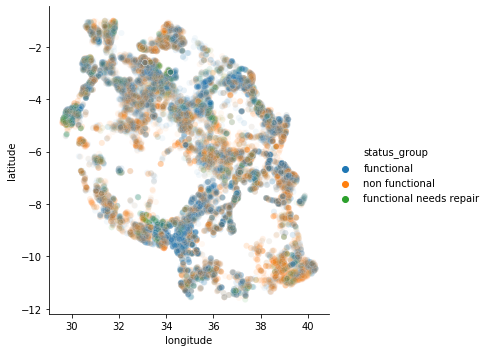

In [87]:
sns.relplot(x='longitude', y='latitude', hue=label, 
            data=X_train, alpha=0.05);

In [94]:
from sklearn.tree import DecisionTreeClassifier

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaler: fit_transform on train, transform on val & test
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Model: Fit on train, score on val, predict on test
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
print('Train Accuracy', dt.score(X_train_scaled, y_train))
print('Validation Accuracy', dt.score(X_val_scaled, y_val))
# y_pred = dt.predict(X_test_scaled)

Train Accuracy 0.9961910774410775
Validation Accuracy 0.7311447811447811


In [108]:
one_hot_cols = [
        'extraction_type_class',
        'payment',
        'quality_group',
        'quantity',
        'source_class',
        'waterpoint_type'
    ]
    
encoder = ce.OneHotEncoder(cols=one_hot_cols, use_cat_names=True)

X_train_hot = encoder.fit_transform(X_train)
X_val_hot = encoder.transform(X_val)
X_test_hot = encoder.transform(X_test)

assert X_train.columns.tolist() == X_val.columns.tolist() == X_test.columns.tolist()

In [109]:
ordinal_cols = [
        'basin',
        'source_type',
        'region',
        'scheme_management',
        'management_group'
    ]
    
encoder = ce.OrdinalEncoder(cols=ordinal_cols)

X_train_encoded = encoder.fit_transform(X_train_hot)
X_val_encoded = encoder.transform(X_val_hot)
X_test_encoded = encoder.transform(X_test_hot)

assert X_train.columns.tolist() == X_val.columns.tolist() == X_test.columns.tolist()

In [113]:
dt = DecisionTreeClassifier(random_state=42, max_depth=20)
dt.fit(X_train_scaled, y_train)
print(dt.score(X_train_scaled, y_train), dt.score(X_val_scaled, y_val))
y_pred = dt.predict(X_test_scaled)

0.9301767676767677 0.7568181818181818


In [112]:
# Scaler: fit_transform on train, transform on val & test
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

print('Train score: ', rf.score(X_train_scaled, y_train))
print('Val score: ', rf.score(X_val_scaled, y_val))

Train score:  0.9961910774410775
Val score:  0.8026094276094277


In [115]:
rf = RandomForestClassifier(max_depth = 50,
                            min_samples_split= 3,
                            n_estimators=500,
                            n_jobs=-1)
rf.fit(X_train_scaled, y_train)

print('Train score: ', rf.score(X_train_scaled, y_train))
print('Val score: ', rf.score(X_val_scaled, y_val))

y_pred = dt.predict(X_test_scaled)

Train score:  0.9902988215488215
Val score:  0.8031144781144781


In [122]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth=15, learning_rate=0.1, n_estimators=300)
gb.fit(X_train_scaled, y_train)

print('Train score: ', gb.score(X_train_scaled, y_train))
print('Val score: ', gb.score(X_val_scaled, y_val))

Train score:  0.9961910774410775
Val score:  0.8025252525252525


In [117]:
# Write submission csv file
sample_submission = pd.read_csv(source + 'sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('rf2_submission.csv', index=False)